<a href="https://colab.research.google.com/github/Azariagmt/Rossmann-Pharmaceuticals-Sales-prediction/blob/notebook/notebooks/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import tensorflow as tf
import keras
import keras.backend as kb
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:

time_series_data = pd.read_csv('/content/time-series.csv', index_col="Date")
# time_series_data = time_series_data.set_index("Date")
print(time_series_data.head())

scaler = MinMaxScaler()
scaler.fit(time_series_data.Sales.values.reshape([-1, 1]))
sales_scaled = scaler.transform(time_series_data.Sales.values.reshape(-1, 1))
time_series_data['SalesScaled'] = sales_scaled
print(time_series_data.tail(10))

print(time_series_data.describe())

            Sales
Date             
2015-07-31   5263
2015-07-31   6064
2015-07-31   8314
2015-07-31  13995
2015-07-31   4822
            Sales  SalesScaled
Date                          
2013-01-01   3113     0.073895
2013-01-01   2646     0.062643
2013-01-01   2907     0.068931
2013-01-01   8498     0.203638
2013-01-01   3821     0.090953
2013-01-01   3375     0.080207
2013-01-01  10765     0.258258
2013-01-01   5035     0.120202
2013-01-01   4491     0.107096
2013-01-01   5961     0.142513
               Sales    SalesScaled
count  844338.000000  844338.000000
mean     6955.959134       0.166485
std      3103.815515       0.074782
min        46.000000       0.000000
25%      4859.000000       0.115962
50%      6369.000000       0.152343
75%      8360.000000       0.200313
max     41551.000000       1.000000


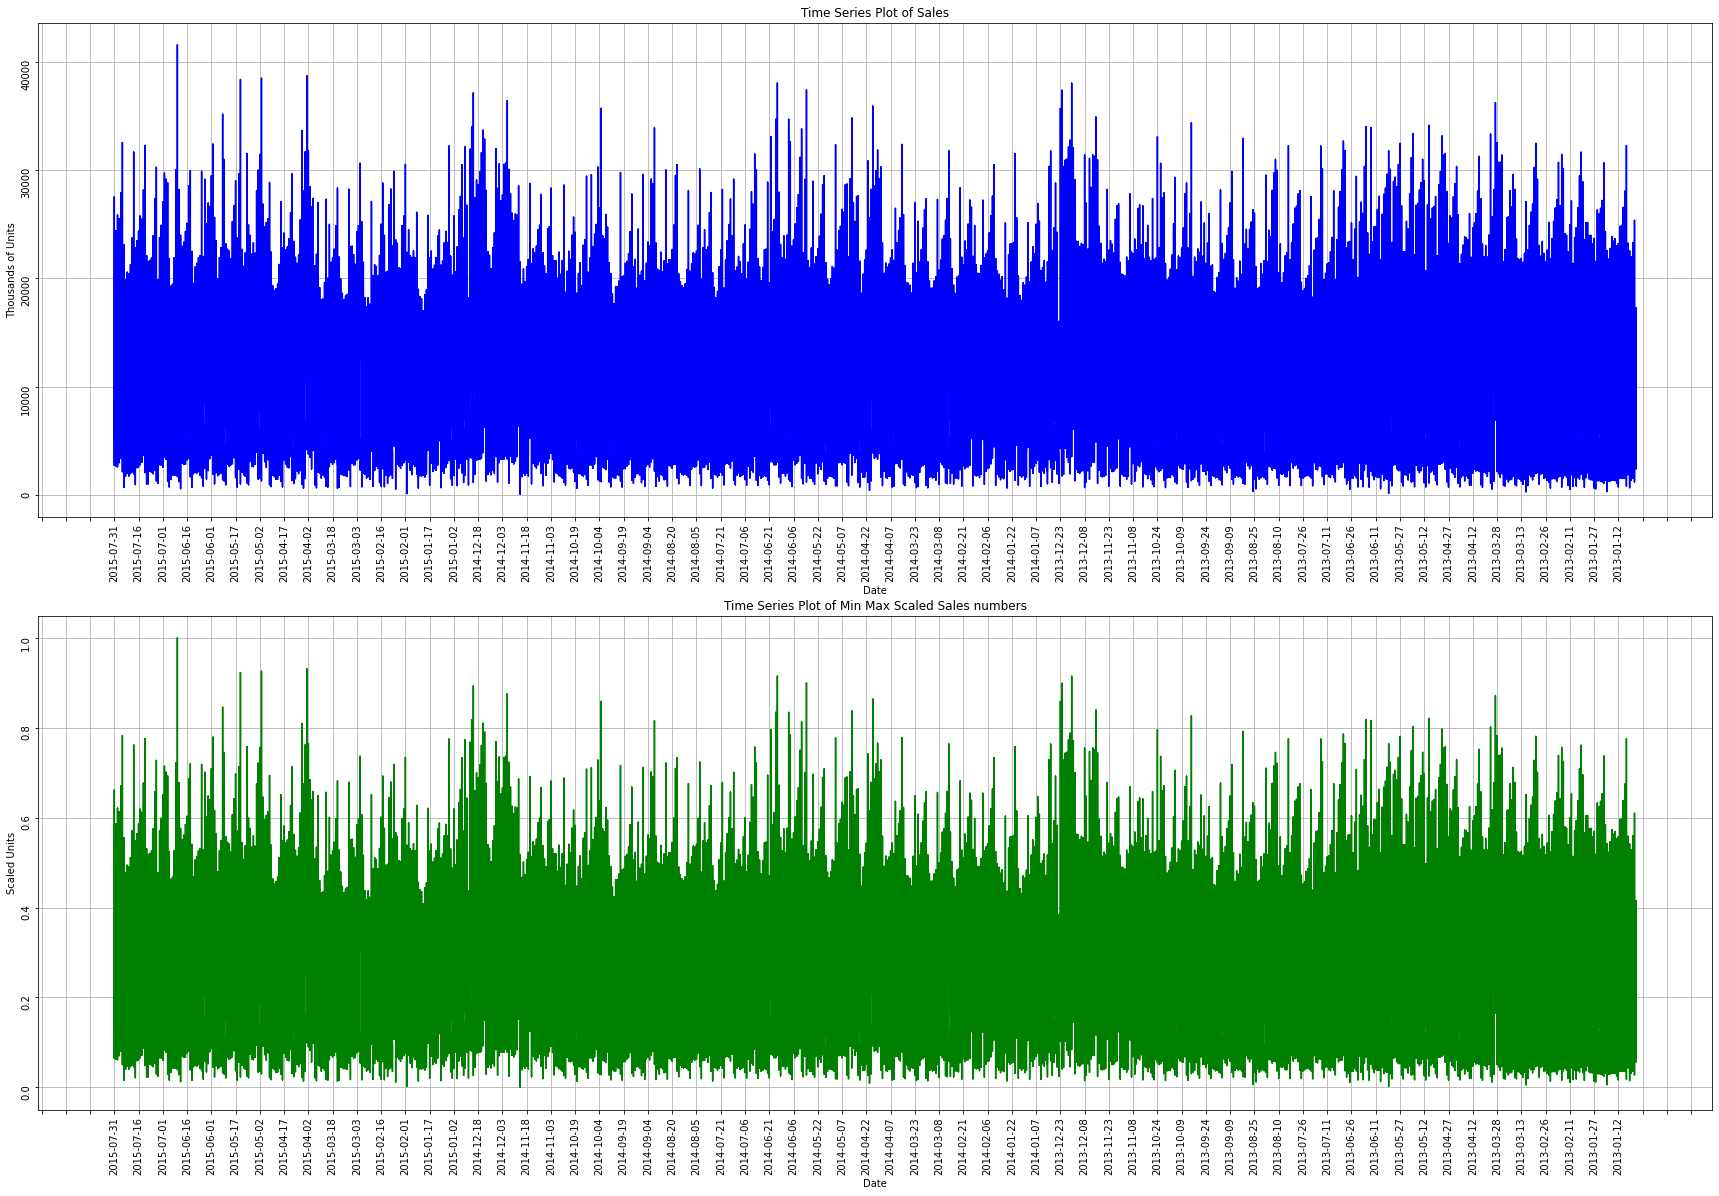

In [22]:

fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(time_series_data.index, time_series_data.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(time_series_data.index, time_series_data.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales numbers')
ax2.grid(True)
plt.show()


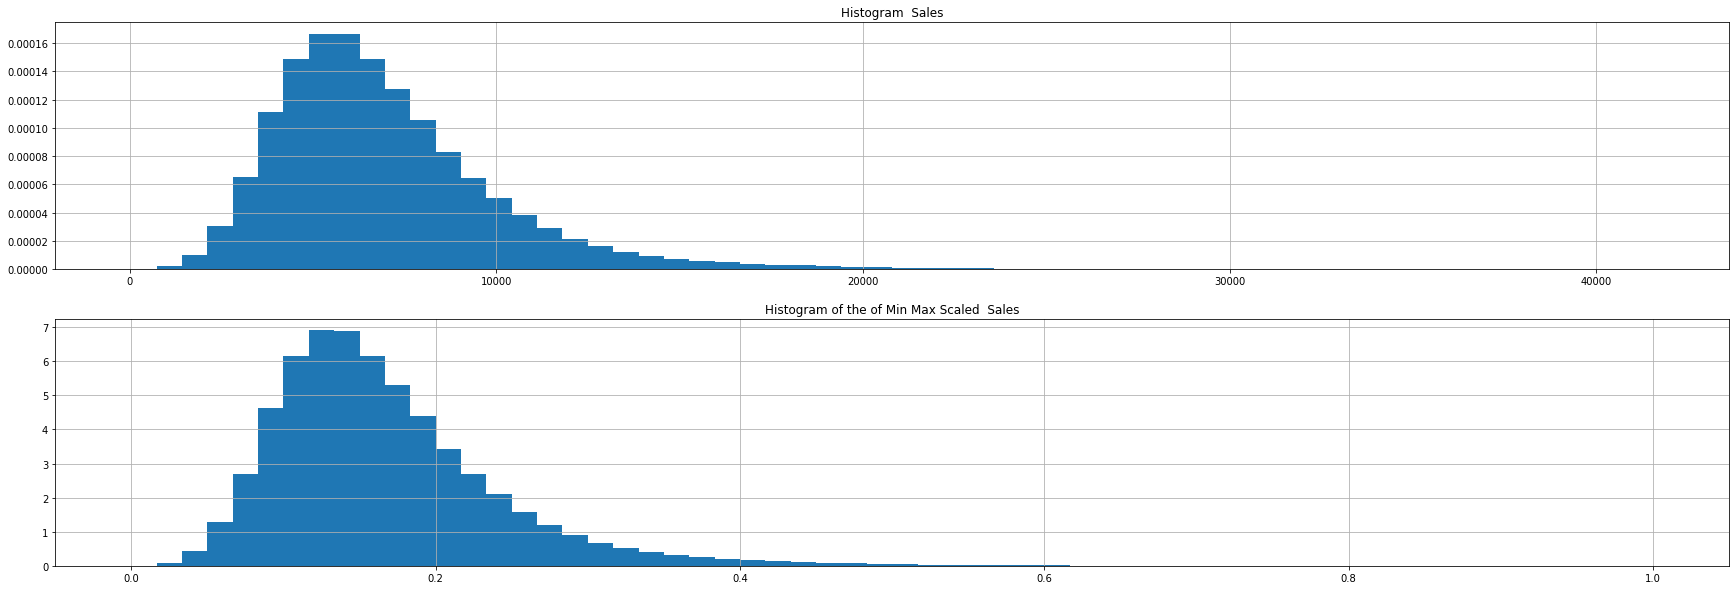

In [23]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(time_series_data.Sales, density=True, bins=60)
ax1.title.set_text('Histogram  Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(time_series_data.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled  Sales')
ax2.grid(True)
plt.show()

In [ ]:
SIZE = len(time_series_data.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [ ]:
DateTrain = time_series_data.index.values[0:BATCH_SIZE]
DateValid = time_series_data.index.values[BATCH_SIZE:]
XTrain = time_series_data.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = time_series_data.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

In [ ]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

In [ ]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

In [ ]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [ ]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [12]:
time_features = time_series_data.index

In [13]:
time_target = time_series_data.SalesScaled

In [15]:
X_train=time_features[:int(time_features.shape[0]*80/100)]
Y_train=time_target[:int(time_target.shape[0]*80/100)]
X_test=time_features[int(time_features.shape[0]*80/100):int(time_series_data.shape[0]*95/100)]
Y_test=time_target[int(time_target.shape[0]*80/100):int(time_series_data.shape[0]*95/100)]
X_val=time_features[int(time_features.shape[0]*95/100):]
Y_val=time_target[int(time_target.shape[0]*95/100):]

In [16]:
time_model=keras.models.Sequential()
time_model.add(keras.layers.Embedding(input_dim=2500, output_dim=4, input_length=8))
time_model.add(keras.layers.LSTM(256, return_sequences=True))
time_model.add(keras.layers.LSTM(256, return_sequences=True))
time_model.add(keras.layers.Dense(64, activation="relu")) 
time_model.add(keras.layers.Dense(1))

In [17]:
time_model.compile(optimizer="adam",metrics=["mean_absolute_error"],loss="mean_squared_error")

In [19]:
X_train.shape

(675470,)

In [18]:
hist=time_model.fit(X_train,Y_train,batch_size=50,epochs=30,validation_data=(X_val,Y_val))

Epoch 1/30


UnimplementedError: ignored